In [210]:
!pip install pmdarima
!pip install statsmodels

In [211]:
!pip install prophet
!pip install pandas-profiling

In [212]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Data Import and Preprocessing

In [213]:
#Import the dataset
data = pd.read_csv(r'C:\Users\admin\Downloads\NSE-TATAGLOBAL.csv')
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [214]:
data['Date'] = pd.to_datetime(data.Date,format='%Y-%m-%d')

In [215]:
#Reverse the order of the dataset so that the latest year data will arrive in the tail of the dataframe
data = data.iloc[::-1]

In [216]:
#View the dataset
data.head(20)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.10,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.30,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
2029,2010-07-28,118.00,120.50,117.20,118.15,118.25,835593,994.01
2028,2010-07-29,112.50,121.70,112.50,117.50,116.60,2359134,2791.03
2027,2010-07-30,116.50,118.00,114.60,115.85,116.05,2656191,3112.68
2026,2010-08-02,117.30,118.50,116.60,118.10,117.30,663593,779.85
2025,2010-08-03,118.30,119.95,117.90,118.65,118.30,611234,726.78


In [217]:
data.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [218]:
data.dtypes

Date                    datetime64[ns]
Open                           float64
High                           float64
Low                            float64
Last                           float64
Close                          float64
Total Trade Quantity             int64
Turnover (Lacs)                float64
dtype: object

In [219]:
data.duplicated().sum()

0

### From the overview above, we can see that the data is clean and does not need any serious cleaning. There are no missing values or any duplicate. Let us move forward

In [220]:
#Use date column as the index
data.reset_index(inplace=True)

In [221]:
data.head()

,index,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
1,2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2,2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
3,2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
4,2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


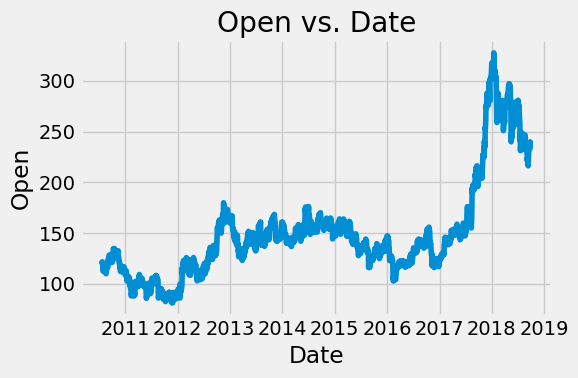

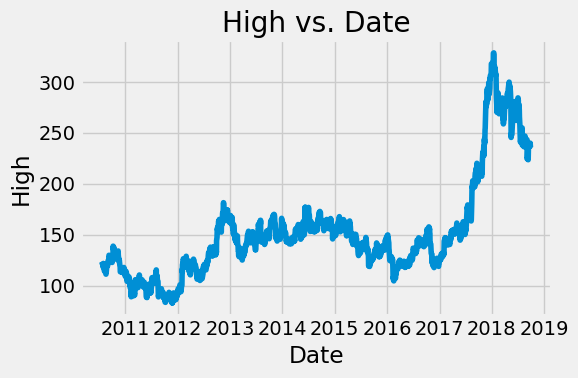

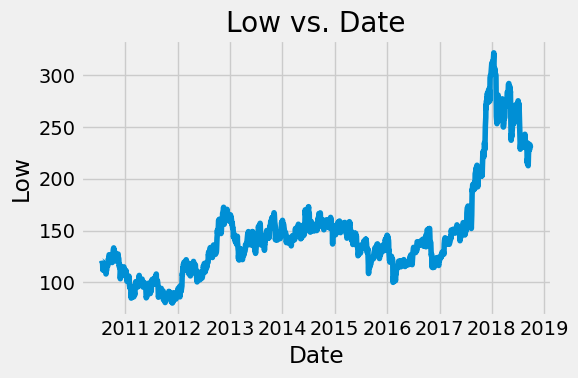

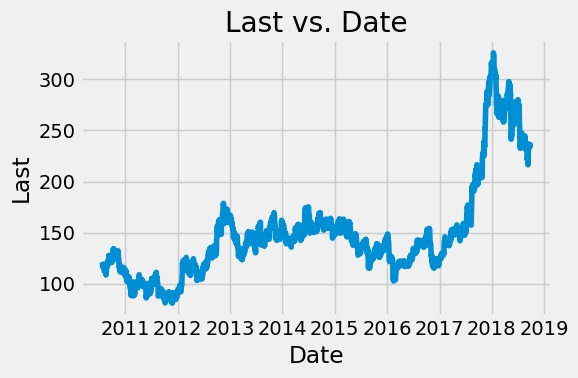

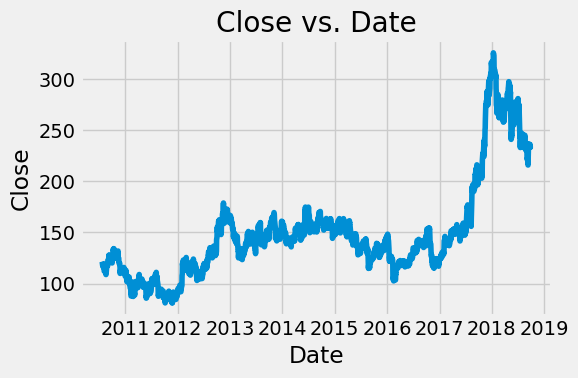

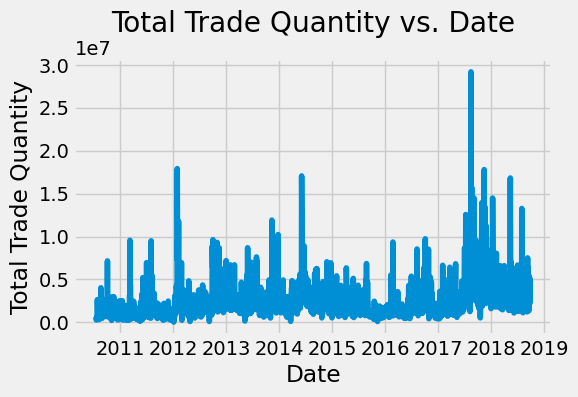

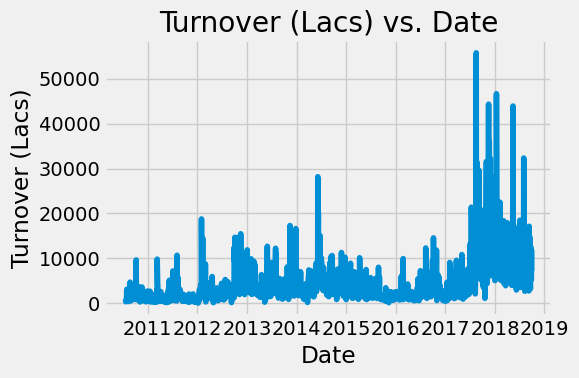

In [222]:
#Plot all the variables against the Date and check for the relationships, patterns and trends
for column in data.columns[2:]:
    plt.figure(figsize=(6,4 ))
    plt.plot(data['Date'], data[column])
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.title(f'{column} vs. Date')
    plt.tight_layout()
    plt.show()

### From above plot, it can be seen that the prices, turnover and total trade quantity is increasing from 2017

# Checking Stationarity

In [223]:
# Define a function which will give us rolling mean and standard deviation and perform ADF Test
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

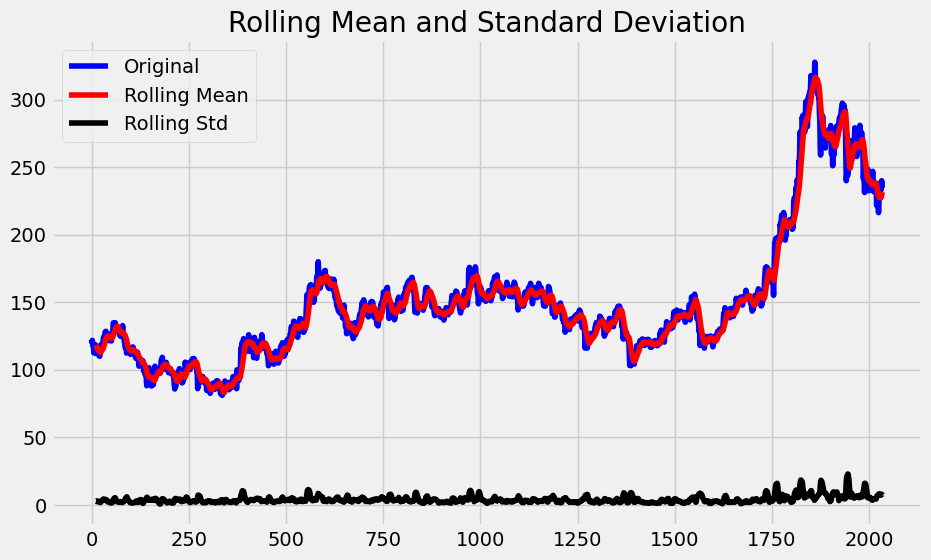

Results of dickey fuller test
Test Statistics                  -0.951734
p-value                           0.770459
No. of lags used                  8.000000
Number of observations used    2026.000000
critical value (1%)              -3.433582
critical value (5%)              -2.862968
critical value (10%)             -2.567530
dtype: float64


In [224]:
test_stationarity(data['Open'])

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.


<Figure size 1000x600 with 0 Axes>

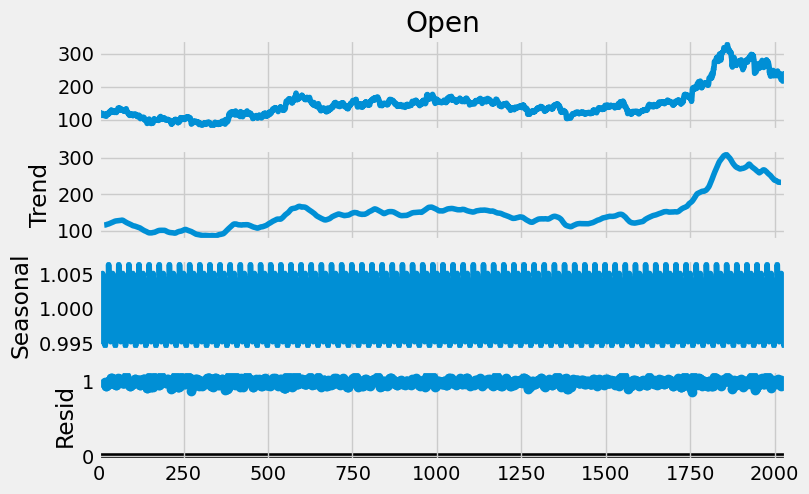

In [225]:
# Decompose the series to separate the trend and the seasonality from a time series, 
result = seasonal_decompose(data['Open'], model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(8, 5)

In [226]:
def test_stationarity(timeseries):
    
    # Transformation to make the data stationary
    timeseries_log = np.log(timeseries)
    timeseries_log_diff = timeseries_log.diff().dropna()

    # Determing rolling statistics
    rolmean = timeseries_log_diff.rolling(window=12).mean()
    rolstd = timeseries_log_diff.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(6, 4))
    plt.plot(timeseries_log_diff, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Log-Difference')
    plt.show()

    # Perform ADF test
    adft = adfuller(timeseries_log_diff, autolag='AIC')

    # Output the ADF test results
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in adft[4].items():
        output[f'Critical Value ({key})'] = value
    print(output)

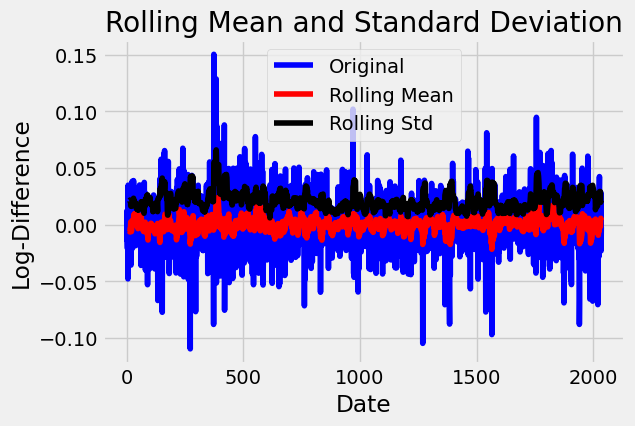

Test Statistic                  -49.577189
p-value                           0.000000
Number of Lags Used               0.000000
Number of Observations Used    2033.000000
Critical Value (1%)              -3.433571
Critical Value (5%)              -2.862963
Critical Value (10%)             -2.567527
dtype: float64


In [227]:
test_stationarity(data['Open'])

Based on the ADF test results above, the test statistic is significantly lower than the critical values at all levels of significance (1%, 5%, and 10%). Additionally, the p-value is very close to zero, indicating strong evidence against the null hypothesis of non-stationarity.

Therefore, based on these results, we can conclude that the time series is stationary after the transformation.

# Model Fitting
## Moving Average

In [228]:
import numpy as np

def moving_avg_prediction(data):
    shape = data.shape[0]
    df_new = data[['Open']]
    df_new['Open'] = np.log(df_new['Open'])  # Apply logarithmic transformation
    
    train_set = df_new.iloc[:ceil(shape * 0.9)]
    valid_set = df_new.iloc[ceil(shape * 0.9):]
    
    print('-----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------')
    print('-----------------------------------------------------------')
    print('Shape of Training Set:', train_set.shape)
    print('Shape of Validation Set:', valid_set.shape)
    
    preds = []
    for i in range(0, valid_set.shape[0]):
        a = train_set['Open'][len(train_set) - valid_set.shape[0] + i:].sum() + sum(preds)
        b = a / (valid_set.shape[0])
        preds.append(b)
    
    rms = np.sqrt(np.mean(np.power((np.array(valid_set['Open']) - preds), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    valid_set['Predictions'] = preds
    
    plt.figure(figsize=(6, 4))
    plt.plot(train_set['Open'])
    plt.plot(valid_set[['Open', 'Predictions']])
    plt.xlabel('Date', size=20)
    plt.ylabel('Log-transformed Open Price', size=20)
    plt.title('Log-transformed Open Price Prediction by Moving Averages', size=20)
    plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])

-----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------
-----------------------------------------------------------
Shape of Training Set: (1832, 1)
Shape of Validation Set: (203, 1)
RMSE value on validation set: 0.3618938504792057
-----------------------------------------------------------
-----------------------------------------------------------


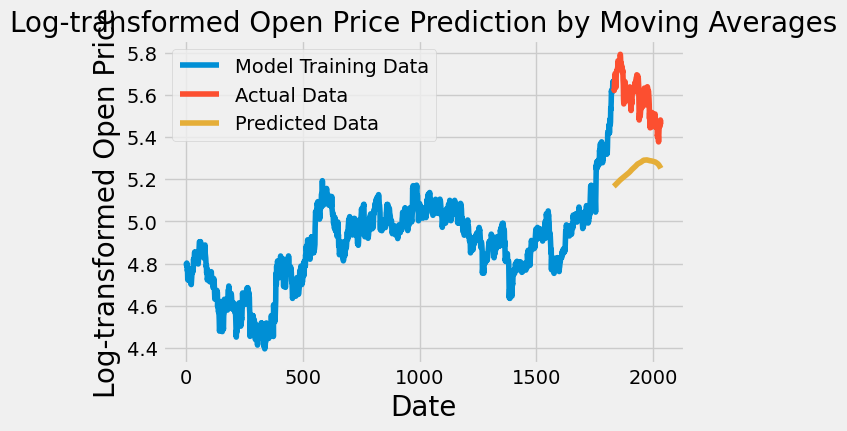

In [229]:
from math import ceil, floor
moving_avg_prediction(data)

##### Interpretation: The RMSE value is close to 0.362 but the results are not that good (as we see from the plot). 

## ARIMA

In [230]:
def moving_avg_prediction(data):
    shape = data.shape[0]
    df_new = data[['Open']]
    df_new['Open'] = np.log(df_new['Open'])  # Apply logarithmic transformation
    
    train_set = df_new.iloc[:ceil(shape * 0.9)]
    valid_set = df_new.iloc[ceil(shape * 0.9):]
    print('----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------------------')
    print('Shape of Training Set:', train_set.shape)
    print('Shape of Validation Set:', valid_set.shape)
    training = train_set['Open']
    validation = valid_set['Open']
    model = auto_arima(training, start_p=0, start_q=0, max_p=3, max_q=3, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
    model.fit(training)
    forecast = model.predict(n_periods=len(validation))
    forecast.index = validation.index
    forecast = pd.DataFrame(forecast,columns =['Prediction'])
    #forecast = pd.DataFrame(forecast, index=valid_set.index, columns=['Prediction'])
    rms = np.sqrt(np.mean(np.power((np.array(validation) - np.array(forecast['Prediction'])), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    plt.figure(figsize=(8, 4))
    plt.plot(train_set['Open'])
    plt.plot(valid_set['Open'])
    plt.plot(forecast['Prediction'])
    plt.xlabel('Date', size=20)
    plt.ylabel('Stock Price', size=20)
    plt.title('Stock Price Prediction by Auto ARIMA', size=20)
    plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])

In [231]:
data.head()

,index,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
1,2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2,2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
3,2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
4,2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [232]:
data.set_index('Date',inplace=True)

In [233]:
data.head()

,index,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2010-07-21,2034,122.1,123.00,121.05,121.10,121.55,658666,803.56
2010-07-22,2033,120.3,122.00,120.25,120.75,120.90,293312,355.17
2010-07-23,2032,121.8,121.95,120.25,120.35,120.65,281312,340.31
2010-07-26,2031,120.1,121.00,117.10,117.10,117.60,658440,780.01
2010-07-27,2030,117.6,119.50,112.00,118.80,118.65,586100,694.98


----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set: (1832, 1)
Shape of Validation Set: (203, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8692.066, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8710.004, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8710.096, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8693.292, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8708.142, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8708.178, Time=1.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8706.122, Time=1.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8711.116, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8709.171, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-8709.170, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-

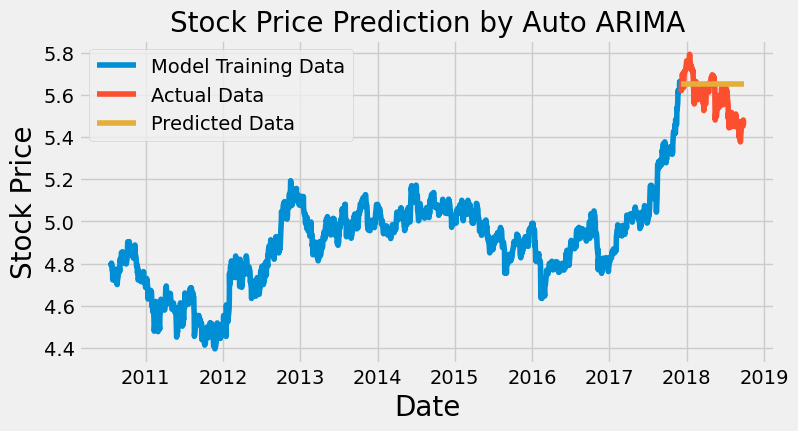

In [234]:
moving_avg_prediction(data)

#### Interpretation: An auto ARIMA model uses past data to understand the pattern in the time series. Using these values, the model captured an increasing trend in the series. Although the predictions using this technique are far better than that of the previously implemented model, these predictions are close than previous moving average model.

# SARIMA

In [235]:
data.head()

,index,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2010-07-21,2034,122.1,123.00,121.05,121.10,121.55,658666,803.56
2010-07-22,2033,120.3,122.00,120.25,120.75,120.90,293312,355.17
2010-07-23,2032,121.8,121.95,120.25,120.35,120.65,281312,340.31
2010-07-26,2031,120.1,121.00,117.10,117.10,117.60,658440,780.01
2010-07-27,2030,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_prediction(data):
    shape = data.shape[0]
    df_new = data[['Open']]
    df_new['Open'] = np.log(df_new['Open'])  # Apply logarithmic transformation
    
    train_set = df_new.iloc[:ceil(shape * 0.9)]
    valid_set = df_new.iloc[ceil(shape * 0.9):]
    print('----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY SARIMA--------------')
    print('----------------------------------------------------------')
    print('Shape of Training Set:', train_set.shape)
    print('Shape of Validation Set:', valid_set.shape)
    training = train_set['Open']
    validation = valid_set['Open']
    
    # Define and fit the SARIMA model
    model = SARIMAX(training, 
                    order=(1, 1, 1), # You may need to adjust these parameters
                    seasonal_order=(1, 1, 1, 12), # Adjust the seasonal_order as needed
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    results = model.fit()
    
    # Forecast
    forecast = results.get_forecast(steps=len(validation))
    forecast_index = valid_set.index
    forecast_mean = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()
    
    forecast_df = pd.DataFrame(forecast_mean, index=forecast_index, columns=['Prediction'])
    
    # Calculate RMSE
    rms = np.sqrt(np.mean(np.power(validation - forecast_df['Prediction'], 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(train_set['Open'], label='Model Training Data')
    plt.plot(valid_set['Open'], label='Actual Data')
    plt.plot(forecast_df['Prediction'], label='Predicted Data', color='red')
    plt.fill_between(forecast_index, 
                     forecast_conf_int.iloc[:, 0], 
                     forecast_conf_int.iloc[:, 1], 
                     color='pink', alpha=0.3)
    plt.xlabel('Date', size=20)
    plt.ylabel('Stock Price', size=20)
    plt.title('Stock Price Prediction by SARIMA', size=20)
    plt.legend()
    plt.show()

# Example usage:
# data = pd.read_csv('your_data.csv', parse_dates=True, index_col='Date')
# sarima_prediction(data)


----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY SARIMA--------------
----------------------------------------------------------
Shape of Training Set: (1832, 1)
Shape of Validation Set: (203, 1)
RMSE value on validation set: nan
-----------------------------------------------------------
-----------------------------------------------------------


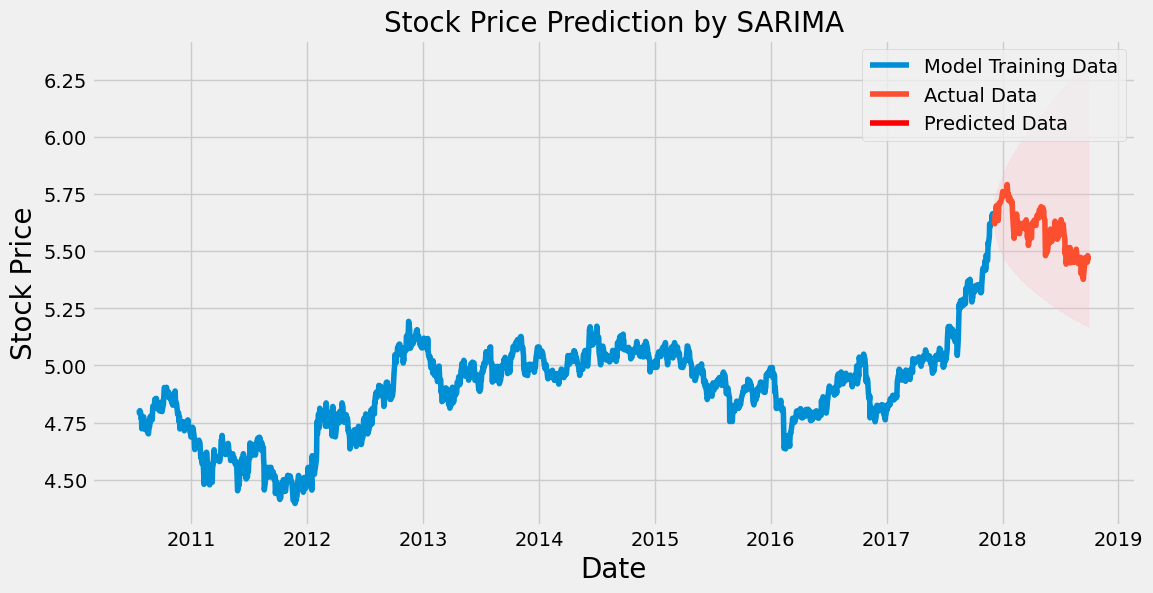

In [240]:
sarima_prediction(data)

In [241]:
data .head()

,index,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2010-07-21,2034,122.1,123.00,121.05,121.10,121.55,658666,803.56
2010-07-22,2033,120.3,122.00,120.25,120.75,120.90,293312,355.17
2010-07-23,2032,121.8,121.95,120.25,120.35,120.65,281312,340.31
2010-07-26,2031,120.1,121.00,117.10,117.10,117.60,658440,780.01
2010-07-27,2030,117.6,119.50,112.00,118.80,118.65,586100,694.98
